# License 
***
Copyright 2017 J. Patrick Hall, jphall@gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Local Interpretable Model Agnostic Explanations (LIME)
***

Based on: Ribeiro, Marco Tulio, Sameer Singh, and Carlos Guestrin. "Why should i trust you?: Explaining the predictions of any classifier." In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, pp. 1135-1144. ACM, 2016.

http://www.kdd.org/kdd2016/papers/files/rfp0573-ribeiroA.pdf

**Instead of perturbing a sample of interest to create a local region in which to fit a linear model, these examples use a practical sample, say all one story homes, from the data to create an approximately local region in which to fit a linear model.**

## Preliminaries: imports, start h2o, load and clean data 

In [1]:
# imports
import h2o 
import operator
import numpy as np
import pandas as pd
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [2]:
# start h2o
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpk5t7btqn
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpk5t7btqn/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpk5t7btqn/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ------------------------------
H2O cluster uptime:         01 secs
H2O cluster version:        3.12.0.1
H2O cluster version age:    2 months and 9 days
H2O cluster name:           H2O_from_python_phall_og2isp
H2O cluster total nodes:    1
H2O cluster free memory:    3.556 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
Python version:             3.5.2 final
--------------------------  ------------------------------

#### Load and prepare data for modeling

In [3]:
# load data
path = '../../03_regression/data/train.csv'
frame = h2o.import_file(path=path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
# assign target and inputs
y = 'SalePrice'
X = [name for name in frame.columns if name not in [y, 'Id']]

#### LIME is simpler to use with data containing no missing values

In [5]:
# determine column types
# impute
reals, enums = [], []
for key, val in frame.types.items():
    if key in X:
        if val == 'enum':
            enums.append(key)
        else: 
            reals.append(key)
            
_ = frame[reals].impute(method='median')
_ = frame[enums].impute(method='mode')

In [6]:
# split into training and validation
train, valid = frame.split_frame([0.7])

#### LIME can be unstable with data in which strong correlations exist between input variables

In [7]:
# print out correlated pairs
corr = train[reals].cor().as_data_frame()
for i in range(0, corr.shape[0]):
    for j in range(0, corr.shape[1]):
        if i != j:
            if np.abs(corr.iat[i, j]) > 0.7:
                print(corr.columns[i], corr.columns[j])

YearBuilt GarageYrBlt
GrLivArea TotRmsAbvGrd
1stFlrSF TotalBsmtSF
TotalBsmtSF 1stFlrSF
TotRmsAbvGrd GrLivArea
GarageCars GarageArea
GarageArea GarageCars
GarageYrBlt YearBuilt


#### Remove one var from each correlated pair

In [8]:
X_reals_decorr = [i for i in reals if i not in  ['GarageYrBlt', 'TotRmsAbvGrd', 'TotalBsmtSF', 'GarageCars']]

## Train a predictive model

In [9]:
# train GBM model
model = H2OGradientBoostingEstimator(ntrees=100,
                                     max_depth=10,
                                     distribution='huber',
                                     learn_rate=0.1,
                                     stopping_rounds=5,
                                     seed=12345)

model.train(y=y, x=X_reals_decorr, training_frame=train, validation_frame=valid)

preds = valid['Id'].cbind(model.predict(valid))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


## Build local linear surrogate models to help interpret the model

#### Create a local region based on HouseStyle

In [10]:
local_frame = preds.cbind(valid.drop(['Id']))
local_frame = local_frame[local_frame['HouseStyle'] == '1Story']
local_frame['predict'] = local_frame['predict'].log()
local_frame.describe()

Rows:209
Cols:82




Id predict MSSubClass MSZoning LotFrontage LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle OverallQual OverallCond YearBuilt YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinSF1 BsmtFinType2 BsmtFinSF2 BsmtUnfSF TotalBsmtSF Heating HeatingQC CentralAir Electrical 1stFlrSF 2ndFlrSF LowQualFinSF GrLivArea BsmtFullBath BsmtHalfBath FullBath HalfBath BedroomAbvGr KitchenAbvGr KitchenQual TotRmsAbvGrd Functional Fireplaces FireplaceQu GarageType GarageYrBlt GarageFinish GarageCars GarageArea GarageQual GarageCond PavedDrive WoodDeckSF OpenPorchSF EnclosedPorch 3SsnPorch ScreenPorch PoolArea PoolQC Fence MiscFeature MiscVal MoSold YrSold SaleType SaleCondition SalePrice 
 
 
 type int real int enum real int enum enum enum enum enum enum enum enum enum enum enum enum int int int int enum enum enum enum enum int enum enum enum enum enum enum enum int enum int int int enum enum enum enum int int int int int int int int int int enum int enum int enum enum real enum int int enum enum enum int int int int int int enum enum enum int int int enum enum int 
 mins 14.0 11.036545441593269 20.0 32.0 3010.0 2.0 3.0 1913.0 1950.0 0.0 0.0 0.0 0.0 0.0 480.0 0.0 0.0 480.0 0.0 0.0 0.0 0.0 0.0 1.0 3.0 0.0 1920.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 2006.0 35311.0 
 mean 687.1291866028708 12.005547541208653 42.057416267942585 70.77917923261715 9969.435406698565 5.947368421052632 5.483253588516747 1974.6076555023924 1984.909090909091 89.69856459330144 574.1052631578947 53.61244019138756 602.0430622009569 1229.7607655502393 1337.6602870813397 2.23444976076555 0.0 1339.8947368421052 0.5789473684210527 0.0430622009569378 1.4784688995215312 0.11961722488038277 2.650717703349282 1.0526315789473684 5.980861244019139 0.5358851674641149 1979.9238578680201 1.7272727272727273 479.52153110047846 111.377990430622 38.79904306220096 17.267942583732058 2.569377990430622 9.229665071770334 3.1004784688995217 19.138755980861244 6.555023923444976 2007.8086124401914 178322.78468899522 
 maxs 1452.0 12.985784787643702 190.0 313.0 50271.0 10.0 9.0 2009.0 2010.0 922.0 1810.0 791.0 2336.0 3094.0 2898.0 467.0 0.0 2898.0 3.0 1.0 3.0 1.0 6.0 2.0 10.0 3.0 2009.0 4.0 1356.0 857.0 304.0 286.0 216.0 224.0 648.0 1200.0 12.0 2010.0 555000.0 
 sigma 422.43200130977914 0.3916492463134954 41.068382877079394 24.43557111295915 5321.718702537052 1.5070683663088231 0.985938121107469 24.489973198543225 20.1376599844756 150.47734958562475 488.1206585752494 155.9077267731607 489.8865086996808 457.11586457436033 398.88055422682845 32.30306546254569 0.0 399.1265805830717 0.5501196042201809 0.20348455090889342 0.5287553875332314 0.32529254125200097 0.7767733815416329 0.22383300599978273 1.2746105079593406 0.612297302582734 21.14726636557282 0.7827913117569955 229.0783598834146 135.56536066875606 58.122035069484006 53.86418976031431 21.584944452443935 39.59731051937812 44.823097258521635 114.00584027036803 2.8416690187150433 1.2978245436848066 77114.87392119177 
 zeros 0 0 0 0 0 0 0 0 0 114 39 182 22 7 0 208 209 0 93 200 2 184 2 0 0 109 0 14 14 95 104 184 206 198 208 202 0 0 0 
 missing 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
 0 14.0 12.268609123183118 20.0 RL 91.0 10652.0 Pave NA IR1 Lvl AllPub Inside Gtl CollgCr Norm Norm 1Fam 1Story 7.0 5.0 2006.0 2007.0 Gable CompShg VinylSd VinylSd Stone 306.0 Gd TA PConc Gd TA Av Unf 0.0 Unf 0.0 1494.0 1494.0 GasA Ex Y SBrkr 1494.0 0.0 0.0 1494.0 0.0 0.0 2.0 0.0 3.0 1.0 Gd 7.0 Typ 1.0 Gd Attchd 2006.0 RFn 3.0 840.0 TA TA Y 160.0 33.0 0.0 0.0 0.0 0.0 NA NA NA 0.0 8.0 2007.0 New Partial 279500.0 
 1 15.0 11.89861004166866 20.0 RL 70.04995836802665 10920.0 Pave NA IR1 Lvl AllPub Corner Gtl NAmes Norm Norm 1Fam 1Story 6.0 5.0 1960.0 1960.0 Hip CompShg 

#### Train penalized linear model in local region 
* Check R<sup>2</sup> to ensure surrogate model is a good fit for predictions
* Use ranked predictions plot to ensure surrogate model is a good fit for predictions
* Use trained GLM and coefficients to understand local region of response function

In [11]:
%matplotlib inline

In [12]:
# initialize
local_glm = H2OGeneralizedLinearEstimator(lambda_search=True)

# train 
local_glm.train(x=X_reals_decorr, y='predict', training_frame=local_frame)

# coefs
print('\nLocal GLM Coefficients:')
for c_name, c_val in sorted(local_glm.coef().items(), key=operator.itemgetter(1)):
    if c_val != 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))
        
# r2
print('\nLocal GLM R-square:\n%.2f' % local_glm.r2())

glm Model Build progress: |███████████████████████████████████████████████| 100%

Local GLM Coefficients:
KitchenAbvGr:             -0.1508258670073023
YrSold:                   -0.0038514394943816705
MSSubClass:               -0.00011210487426281287
EnclosedPorch:            -9.130093138694107e-05
2ndFlrSF:                 -3.9194722085630606e-05
MoSold:                   -1.5547455415244997e-05
LotArea:                  3.329666938941041e-06
MiscVal:                  6.695561375680934e-06
OpenPorchSF:              7.334408876566789e-05
GrLivArea:                7.801707438135216e-05
WoodDeckSF:               8.338161186914433e-05
ScreenPorch:              9.387310676953871e-05
BsmtFinSF1:               0.00010125805853647395
GarageArea:               0.00016468298708688275
1stFlrSF:                 0.000240835733035765
HalfBath:                 0.0004316804511827515
LotFrontage:              0.0005389665055779621
YearRemodAdd:             0.0010353227962118725
BsmtFullBath:          

glm prediction progress: |████████████████████████████████████████████████| 100%


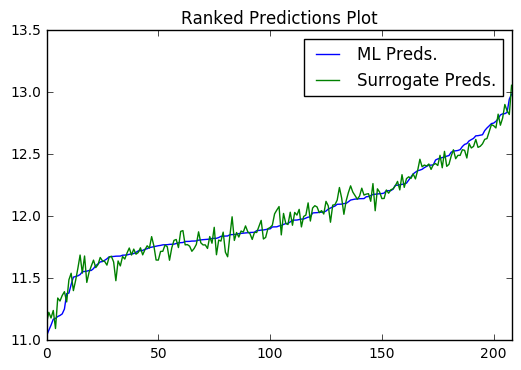

In [13]:
# ranked predictions plot
pred_frame = local_frame.cbind(local_glm.predict(local_frame))\
                        .as_data_frame()[['predict', 'predict0']]
pred_frame.columns = ['ML Preds.', 'Surrogate Preds.']
pred_frame.sort_values(by='ML Preds.', inplace=True)
pred_frame.reset_index(inplace=True, drop=True)
_ = pred_frame.plot(title='Ranked Predictions Plot')

A ranked predictions plot is a way to visually check whether the surrogate model is a good fit for the complex model. The y-axis is the numeric prediction of both models for a given point. The x-axis is the rank of a point when the predictions are sorted by their GBM prediction, from lowest on the left to highest on the right. When both sets of predictions are aligned, as they are above, this a good indication that the linear model fits the complex, nonlinear GBM well in the approximately local region.

Both the R<sup>2</sup> and ranked predictions plot show the linear model is a good fit in the practical, approximately local sample. This means the regression coefficients are likely a very accurate representation of the behavior of the nonlinear model in this region.

#### Create explanations (or 'reason codes') for a row in the local set
The local glm coefficient multiplied by the value in a specific row are estimates of how much each variable contributed to each prediction decision. These values can tell you how a variable and it's values were weighted in any given decision by the model. These values are crucially important for machine learning interpretability and are often to referred to "local feature importance", "reason codes", or "turn-down codes." The latter phrases are borrowed from credit scoring. Credit lenders must provide reasons for turning down a credit application, even for automated decisions. Reason codes can be easily extracted from LIME local feature importance values, by simply ranking the variables that played the largest role in any given decision.

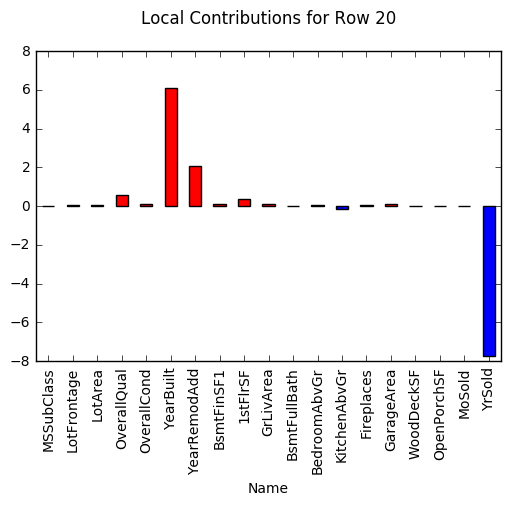

In [14]:
row = 20 # select a row to describe
local_contrib_frame = pd.DataFrame(columns=['Name', 'Local Contribution', 'Sign'])

# multiply values in row by local glm coefficients
for name in local_frame[row, :].columns:
    contrib = 0.0
    try:
        contrib = local_frame[row, name]*local_glm.coef()[name]
    except:
        pass
    if contrib != 0.0:
        local_contrib_frame = local_contrib_frame.append({'Name':name,
                                                          'Local Contribution': contrib,
                                                          'Sign': contrib > 0}, 
                                                         ignore_index=True)

# plot
_ = local_contrib_frame.plot(x = 'Name',
                             y = 'Local Contribution',
                             kind='bar', 
                             title='Local Contributions for Row ' + str(row) + '\n', 
                             color=local_contrib_frame.Sign.map({True: 'r', False: 'b'}), 
                             legend=False)          

#### Create a local region based on predicted SalePrice quantiles

In [15]:
local_frame = preds.cbind(valid.drop(['Id'])).as_data_frame()
local_frame.sort_values('predict', axis=0, inplace=True)
local_frame = local_frame.iloc[0: local_frame.shape[0]//10, :]
local_frame = h2o.H2OFrame(local_frame)
local_frame['predict'] = local_frame['predict'].log()
local_frame.describe()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Rows:44
Cols:82




Id predict MSSubClass MSZoning LotFrontage LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle OverallQual OverallCond YearBuilt YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinSF1 BsmtFinType2 BsmtFinSF2 BsmtUnfSF TotalBsmtSF Heating HeatingQC CentralAir Electrical 1stFlrSF 2ndFlrSF LowQualFinSF GrLivArea BsmtFullBath BsmtHalfBath FullBath HalfBath BedroomAbvGr KitchenAbvGr KitchenQual TotRmsAbvGrd Functional Fireplaces FireplaceQu GarageType GarageYrBlt GarageFinish GarageCars GarageArea GarageQual GarageCond PavedDrive WoodDeckSF OpenPorchSF EnclosedPorch 3SsnPorch ScreenPorch PoolArea PoolQC Fence MiscFeature MiscVal MoSold YrSold SaleType SaleCondition SalePrice 
 
 
 type int real int enum real int enum enum enum enum enum enum enum enum enum enum enum enum int int int int enum enum enum enum enum int enum enum enum enum enum enum enum int enum int int int enum enum enum enum int int int int int int int int int int enum int enum int enum enum real enum int int enum enum enum int int int int int int enum enum enum int int int enum enum int 
 mins 30.0 10.968339120935102 20.0 21.0 1596.0 2.0 3.0 1892.0 1950.0 0.0 0.0 0.0 0.0 0.0 372.0 0.0 0.0 480.0 0.0 0.0 0.0 0.0 1.0 1.0 3.0 0.0 1920.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 2006.0 35311.0 
 mean 656.5454545454544 11.412471417415036 69.88636363636363 54.774998107637586 6930.522727272727 4.340909090909091 5.454545454545455 1938.9090909090908 1964.4545454545455 14.068181818181818 183.11363636363637 25.886363636363637 427.568181818182 636.5681818181822 784.2954545454546 209.50000000000003 5.318181818181818 999.1136363636363 0.25000000000000006 0.022727272727272728 1.0909090909090913 0.11363636363636363 2.340909090909091 1.1136363636363633 5.295454545454544 0.11363636363636363 1966.070423231591 0.8181818181818182 223.54545454545453 42.88636363636364 17.15909090909091 37.65909090909091 0.0 0.0 0.0 90.9090909090909 6.25 2007.8863636363633 95765.61363636363 
 maxs 1405.0 11.592682530778966 190.0 140.0 21750.0 6.0 9.0 1977.0 2006.0 381.0 1440.0 499.0 994.0 1440.0 1440.0 994.0 234.0 2372.0 2.0 1.0 2.0 1.0 4.0 2.0 11.0 2.0 1998.0 3.0 936.0 321.0 287.0 286.0 0.0 0.0 0.0 3500.0 12.0 2010.0 150000.0 
 sigma 427.57740789978624 0.16918497542025435 60.95641443595537 21.1543469370321 3959.5263370035746 0.9386576714124697 1.5166447891614192 23.893969446254026 18.047037437033808 62.471722990177895 294.3891757291177 91.37482628980807 332.9897266190454 306.01674963485647 214.22815261820085 283.3505101952474 35.27682731559835 315.365805752038 0.4882336459352794 0.15075567228888181 0.36204726777242763 0.32103822064055043 0.7134319875402745 0.32103822064055043 1.4560147177659126 0.3867520743564635 19.044164062233055 0.755529300763972 213.9337492043408 78.70794289550093 54.01978241512631 66.17698018292371 0.0 0.0 0.0 531.2636019897791 3.4108240837417223 1.3845645624108944 23115.542274867905 
 zeros 0 0 0 0 0 0 0 0 0 41 22 40 10 5 0 27 43 0 34 43 1 39 0 0 0 40 0 16 16 30 38 30 44 44 44 42 0 0 0 
 missing 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
 0 706.0 10.968339120935102 190.0 RM 70.0 5600.0 Pave nan Reg Lvl AllPub Inside Gtl IDOTRR Norm Norm 2fmCon 2Story 4.0 5.0 1930.0 1950.0 Hip CompShg VinylSd Wd Shng None 0.0 Fa Fa Slab nan nan nan nan 0.0 nan 0.0 0.0 0.0 GasA Fa N SBrkr 372.0 720.0 0.0 1092.0 0.0 0.0 2.0 0.0 3.0 2.0 Fa 7.0 Mod 0.0 nan nan 1978.5061638868744 nan 0.0 0.0 nan nan N 0.0 0.0 0.0 0.0 0.0 0.0 nan nan Othr 3500.0 7.0 2010.0 WD Normal 55000.0 
 1 621.0 11.036545441593269 30.0 RL 45.0 8248.0 Pave Grvl Reg Lvl AllPub Inside Gtl Edwards Norm Norm 1Fam 1Story 3.0 3.0 1914.0 1950.0 Gable CompShg Stucco Stucco None 0.0 TA TA BrkTil TA TA No BLQ 41.0 Unf 0.0 823.0 864.0 GasA TA N Fuse

#### Train penalized linear model in local region 

glm Model Build progress: |███████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%

Local GLM R-square:
0.87

Local GLM Coefficients:
FullBath:                 -0.10560466842690448
HalfBath:                 -0.1011673167208127
MoSold:                   -0.008566732387828832
YrSold:                   -0.002307356382236561
EnclosedPorch:            -0.00047646418589632216
MiscVal:                  -7.659111768804664e-05
BsmtFinSF2:               -4.009348055311646e-06
2ndFlrSF:                 2.760992025667719e-07
BsmtFinSF1:               1.0698104588444621e-05
LowQualFinSF:             4.571947416837975e-05
WoodDeckSF:               5.7321738441605914e-05
GarageArea:               0.00017678332091345634
GrLivArea:                0.0003117252960306305
LotFrontage:              0.00095008001255757
YearRemodAdd:             0.001492563117669517
YearBuilt:                0.002536554911375407
BedroomAbvGr:      

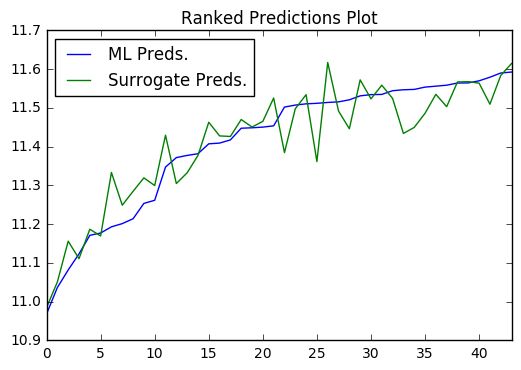

In [16]:
# initialize
local_glm = H2OGeneralizedLinearEstimator(lambda_search=True)

# train 
local_glm.train(x=X_reals_decorr, y='predict', training_frame=local_frame)

# ranked predictions plot
pred_frame = local_frame.cbind(local_glm.predict(local_frame))\
                        .as_data_frame()[['predict', 'predict0']]
pred_frame.columns = ['ML Preds.', 'Surrogate Preds.']
pred_frame.sort_values(by='ML Preds.', inplace=True)
pred_frame.reset_index(inplace=True, drop=True)
_ = pred_frame.plot(title='Ranked Predictions Plot')

# r2
print('\nLocal GLM R-square:\n%.2f' % local_glm.r2())

# coefs
print('\nLocal GLM Coefficients:')
for c_name, c_val in sorted(local_glm.coef().items(), key=operator.itemgetter(1)):
    if c_val != 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))

Here the R<sup>2</sup> and ranked predictions plot show a slightly less accurate fit in the local sample. So the regression coefficients and reason codes may be a bit more approximate than those in the first example.

#### Create explanations (or 'reason codes') for a row in the local set

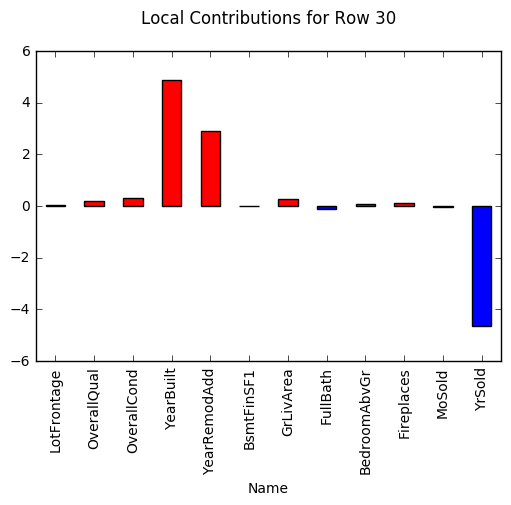

In [17]:
row = 30 # select a row to describe
local_contrib_frame = pd.DataFrame(columns=['Name', 'Local Contribution', 'Sign'])

# multiply values in row by local glm coefficients
for name in local_frame[row, :].columns:
    contrib = 0.0
    try:
        contrib = local_frame[row, name]*local_glm.coef()[name]
    except:
        pass
    if contrib != 0.0:
        local_contrib_frame = local_contrib_frame.append({'Name':name,
                                                          'Local Contribution': contrib,
                                                          'Sign': contrib > 0}, 
                                                         ignore_index=True)
# plot            
_ = local_contrib_frame.plot(x = 'Name',
                             y = 'Local Contribution',
                             kind='bar', 
                             title='Local Contributions for Row ' + str(row) + '\n', 
                             color=local_contrib_frame.Sign.map({True: 'r', False: 'b'}),
                             legend=False)

#### Shutdown H2O

In [18]:
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_bca1 closed.
